In [1]:
import pandas as pd
from glob import glob
import itertools
from collections import Counter
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import time
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import powerlaw
from sklearn import linear_model
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.formula.api as smf

/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/

# clean data

In [26]:
columns = 'user_id，sex，age，occupation_name，education_name，user_opentime，brand_name，call_duration_m，gprs_flow，\
call_fee，gprs_fee，databusiness_fee，order_name，brand_chn，model_chn，screensize，operation_sys，terminal_price，\
dept_county_name，dept_name'.split('，')

basename=pd.read_csv('./basename.csv', encoding='gbk', names=columns)

FileNotFoundError: File b'./basename.csv' does not exist

In [4]:
# extract the valid information and delete the nan,0,‘不详’
basename_except=basename.drop(['order_name'],axis=1)
basename_except=basename_except.drop_duplicates()

basename_except['sex']=basename_except['sex'].replace('不详',np.nan)

basename_except['age']=basename_except['age'].replace(0,np.nan)

basename_except['terminal_price']=basename_except['terminal_price'].replace(0,np.nan)

basename_except['dept_county_name']=basename_except['dept_county_name'].replace('分公司不详',np.nan)

basename_except['dept_name']=basename_except['dept_name'].replace('片区不详',np.nan)

basename_except['databusiness_fee']=basename_except['databusiness_fee'].replace(np.nan,0)

In [6]:
house_pricing = pd.read_csv('./STAYsWithHP.csv',names = ['UserID','stays','headidentifier','headerIdentifier','Home_Lon',
'Home_Lat','Work_Lon','Work_Lat','Gender','Age','PlanFee','PhonePrice','HousePrice'])

In [7]:
diction = dict(house_pricing[['UserID','HousePrice']].values)
basename_except['HousePrice'] = basename_except['user_id'].apply(lambda x: diction[x]
                                                    if x in diction
                                                    else np.nan)

In [8]:
basename_except['fees']=basename_except['call_fee']+basename_except['gprs_fee']+basename_except['databusiness_fee']

In [9]:
basename_except.to_csv('./basename_except.csv', header = False, index = False)

# user profile information

In [2]:
# columns = 'user_id，sex，age，occupation_name，education_name，user_opentime，brand_name，call_duration_m，gprs_flow，\
# call_fee，gprs_fee，databusiness_fee，brand_chn，model_chn，screensize，operation_sys，terminal_price，\
# dept_county_name，dept_name，house_price，fees，record，location'.split('，')

basename_except = pd.read_csv('./basename_except.csv')

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
basename_except['brand_chn']=basename_except['brand_chn'].replace('苹果','Apple')

basename_except['brand_chn']=basename_except['brand_chn'].replace('三星','Samsung')
basename_except['brand_chn']=basename_except['brand_chn'].replace('联想','Lenovo')
basename_except['brand_chn']=basename_except['brand_chn'].replace('小米','MI')
basename_except['brand_chn']=basename_except['brand_chn'].replace('华为','Huawei')
basename_except['brand_chn']=basename_except['brand_chn'].replace('酷派','Coolpad')
basename_except['brand_chn']=basename_except['brand_chn'].replace('索尼','Sony')
basename_except['brand_chn']=basename_except['brand_chn'].replace('摩托罗拉','MOTO')

basename_except['brand_chn']=basename_except['brand_chn'].replace('诺基亚','Nokia')


In [4]:
x=basename_except['brand_chn'].unique()
basename_except['brand_chn']=basename_except['brand_chn'].replace(list(set(x)-set(['Apple','Samsung','Lenovo','MI','Huawei','Coolpad','Sony','MOTO','Nokia'])),'Others')
basename_except['sex']=basename_except['sex'].replace('男','Male')
basename_except['sex']=basename_except['sex'].replace('女','Female')

In [30]:
basename_except.head()

user_id     sex   age  occupation_name education_name  user_opentime  \
0  50785931    Male  75.0              NaN            NaN     20090102.0   
1  42280517  Female   NaN              NaN            NaN     20100227.0   
2  40688293    Male  24.0              NaN            NaN     20051226.0   
3  31430787    Male  28.0              NaN            NaN     20060211.0   
4  35548330  Female   NaN              NaN            NaN     20060115.0   

  brand_name  call_duration_m  gprs_flow  call_fee    ...          model_chn  \
0        神州行            515.0      51.92       NaN    ...              LT22I   
1        神州行            320.0      28.41     16.56    ...           IPHONE 4   
2       动感地带            283.0     132.16     25.00    ...           IPHONE 5   
3        全球通           2447.0     339.84    295.52    ...           IPHONE 5   
4       动感地带           1330.0     110.28     39.08    ...     DESIRE S (G12)   

   screensize operation_sys terminal_price  dept_county_name dept_name  \
0         4.0       ANDROID         1699.0             大兴分公司       庞各庄   
1         3.0           IOS         2599.0             通州分公司      西部片区   
2         4.0           IOS         4199.0            城区三分公司    中关村片区1   
3         4.0           IOS         4199.0            城区二分公司      东城片区   
4         3.0       ANDROID            NaN            城区二分公司      宣武片区   

   house_price    fees   record  location  
0      40007.0     NaN   7686.0      15.0  
1      18609.0   34.56   2105.0      16.0  
2      40252.0     NaN   7909.0      68.0  
3      41821.0  338.60  20385.0      82.0  
4      31774.0   39.08   4337.0      62.0  

[5 rows x 23 columns]

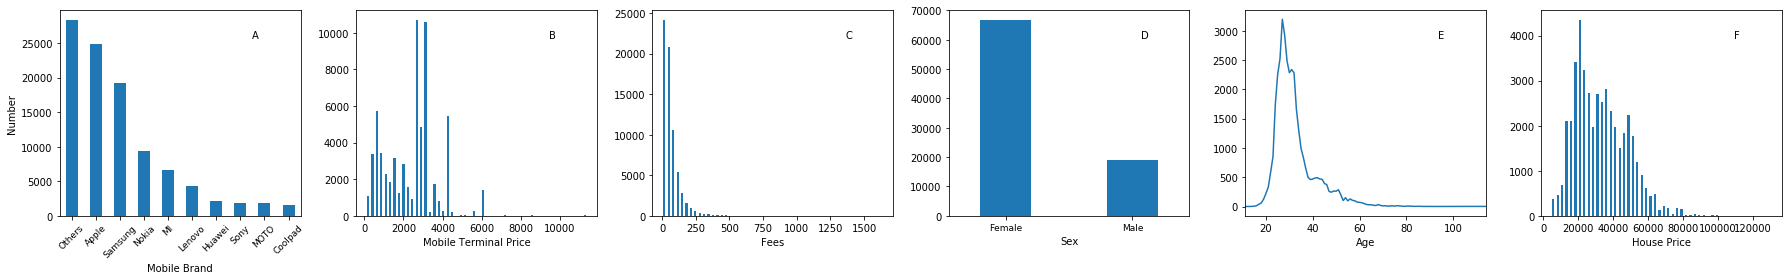

In [58]:
fig=plt.figure(figsize=(25,4),facecolor='white') 
# cmap = cm.get_cmap('Accent',5)

ax=fig.add_subplot(1,6,1)
counts=basename_except['brand_chn'].value_counts()
counts.plot.bar(rot=False)
plt.xticks(rotation=45,fontsize=9)
plt.xlabel('Mobile Brand')
plt.ylabel('Number')
ax.text(0.8, 0.9,'A',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)
# plt.show()

ax=fig.add_subplot(1,6,2)
plt.hist(basename_except[basename_except['terminal_price'].notnull()]['terminal_price'].values,bins=50,rwidth=0.5)
plt.xlabel('Mobile Terminal Price')
# plt.show()
# plt.tight_layout()
ax.text(0.8, 0.9,'B',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)

ax=fig.add_subplot(1,6,3)
plt.hist(basename_except[basename_except['fees'].notnull()]['fees'].values,bins=50,rwidth=0.5)
# plt.xticks(range(0,400,20))
plt.xlabel('Fees')
ax.text(0.8, 0.9,'C',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)

ax=fig.add_subplot(1,6,4)
counts=basename_except['sex'].value_counts()
counts.plot.bar(width=0.4)
plt.xticks(rotation=0,fontsize=9)
plt.xlabel('Sex')
ax.text(0.8, 0.9,'D',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)

ax=fig.add_subplot(1,6,5)
counts1=basename_except['age'].value_counts()
counts1=counts1.sort_index()
plt.xlabel('Age')
counts1.plot()
ax.text(0.8, 0.9,'E',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)


ax=fig.add_subplot(1,6,6)
plt.hist(basename_except[basename_except['house_price'].notnull()]['house_price'].values,bins=50,rwidth=0.5)
# plt.xticks(range(0,1400,200))
plt.xlabel('House Price')
ax.text(0.8, 0.9,'F',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)

plt.tight_layout()
plt.savefig('./Picture/profile.png',dpi=100)
plt.show()

In [11]:
for c in [x for x in columns]:
    print(c,basename_except[c].dropna().count())

user_id 100000
sex 85879
age 36622
occupation_name 0
education_name 2
user_opentime 99998
brand_name 99997
call_duration_m 99998
gprs_flow 99998
call_fee 82710
gprs_fee 79442
databusiness_fee 100000
brand_chn 86363
model_chn 86363
screensize 86363
operation_sys 81070
terminal_price 64227
dept_county_name 94574
dept_name 89727
house_price 45775
fees 68153


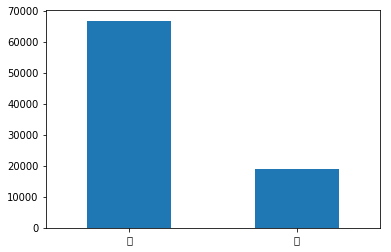

女    66811
男    19068
Name: sex, dtype: int64

In [56]:
counts=basename_except['sex'].value_counts()
counts.plot.bar(rot=False)
plt.show()
counts

In [61]:
basename_except['user_opentime']=basename_except['user_opentime'].dropna().map(lambda x: int(x/10000))                                    

In [12]:
basename_except['fees'].describe()

count    68153.000000
mean        64.667808
std         66.871978
min          0.000000
25%         24.780000
50%         46.180000
75%         81.680000
max       1643.310000
Name: fees, dtype: float64

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


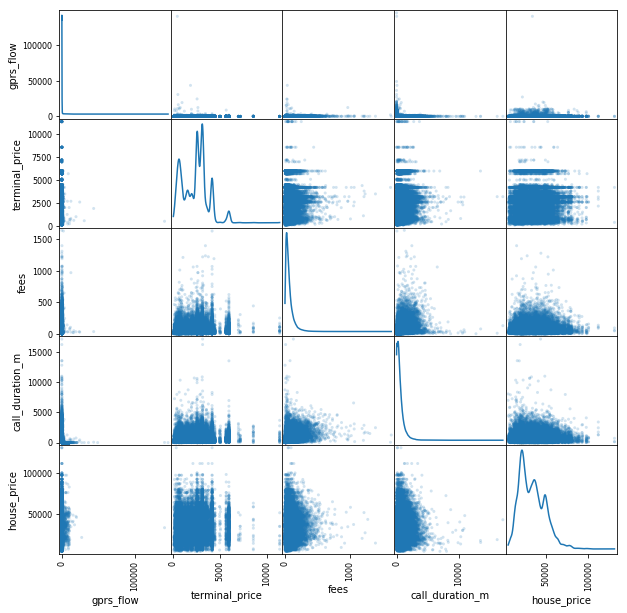

In [8]:
data=basename_except[['gprs_flow','terminal_price','fees','call_duration_m','house_price']]
scatter_matrix(data,alpha=0.2,figsize=(10,10),diagonal='kde')
plt.show()

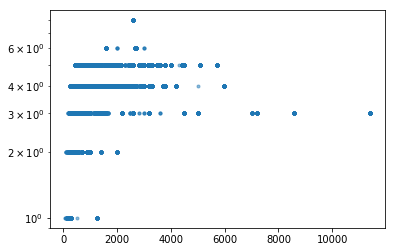

In [52]:
x=basename_except['terminal_price']
y=basename_except['screensize']
plt.plot(x, y,'.', alpha = .5)
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [15]:
basename_except = basename_except.fillna(basename_except.mean())


http://wiki.swarma.net/index.php?title=python&variant=zh

In [25]:
import scipy.interpolate
def densityPlot(x,y):
    rx = (x.max()-x.min())/20
    ry = (y.max()-y.min())/20
    z=[]
    for x0,y0 in zip(x,y):
        n=0
        for x1,y1 in zip(x,y):
            if np.abs(x1-x0)<=rx and np.abs(y1-y0)<=ry:
                n+=1
        z.append(n)
    z=np.array(z)
    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',cmap = plt.get_cmap('gray'),
               extent=[x.min(), x.max(), y.min(), y.max()])
    plt.scatter(x, y, c= z,s=5, edgecolors='none',alpha=0.7)
    plt.colorbar()
    plt.show()

densityPlot(x, y)

KeyboardInterrupt: 

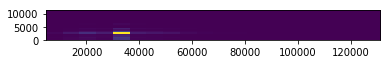

In [32]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
xx = sm.add_constant(x, prepend=True)
res = sm.OLS(y,xx).fit()
constant, beta = res.params
#plt.plot(x,y,".",color="m")
plt.imshow(heatmap[:,::-1].T, extent=extent)
plt.axis(extent)
plt.show()

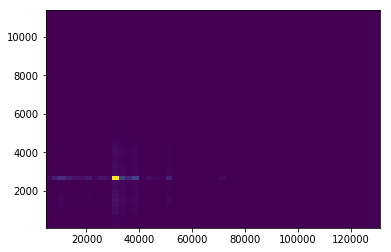

In [26]:
H, xedges, yedges = np.histogram2d(x, y, bins=50)
plt.pcolor(xedges, yedges, H)

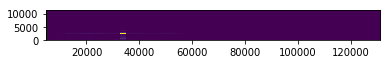

In [21]:
x = basename_except['house_price']
y = basename_except['terminal_price']
# plt.subplot(121)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap[:,::-1].T, extent=extent)
# plt.subplot(122) 
# H, xedges, yedges = np.histogram2d(x, y, bins=50)
# plt.pcolor(xedges, yedges, H)
# plt.show()

In [47]:
basename_exceptnan=basename_except[['fees','terminal_price']].dropna(axis=0,how='any')

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


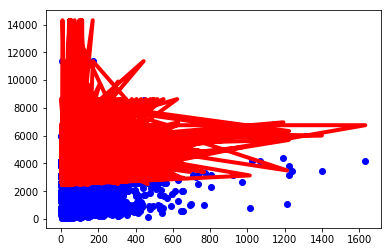

In [50]:
# 建立线性回归模型
regr = linear_model.LinearRegression()

# 拟合
regr.fit(basename_exceptnan['fees'].reshape(-1, 1), basename_exceptnan['terminal_price']) # 注意此处.reshape(-1, 1)，因为X是一维的！

# 不难得到直线的斜率、截距
a, b = regr.coef_, regr.intercept_


# 画图
# 1.真实的点
plt.scatter(basename_exceptnan['fees'], basename_exceptnan['terminal_price'], color='blue')

# 2.拟合的直线
plt.plot(basename_exceptnan['fees'], regr.predict(basename_exceptnan['terminal_price'].reshape(-1,1)), color='red', linewidth=4)

plt.show()

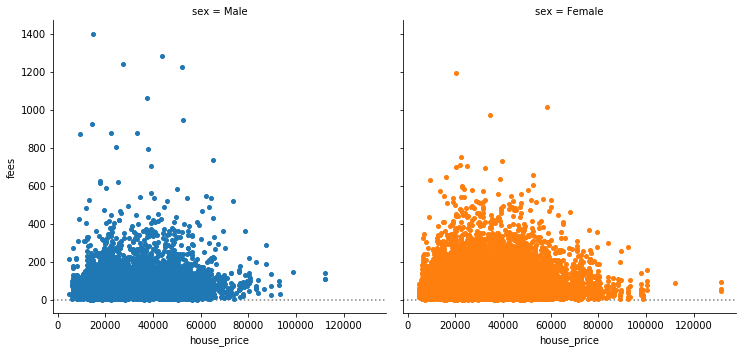

In [16]:
df=basename_except[["house_price", "fees", "sex"]]

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="sex", hue="sex", col_wrap=5, size=5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "house_price", "fees", marker="o",linestyle = '', ms=4)

# Adjust the tick positions and labels
# grid.set(xticks=np.arange(5), yticks=[-3, 3],
#          xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
# grid.fig.tight_layout(w_pad=1)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [18]:
basename_except['age'].describe()

count    36622.000000
mean        32.168806
std          8.658270
min         11.000000
25%         27.000000
50%         30.000000
75%         35.000000
max        114.000000
Name: age, dtype: float64

In [57]:
basename_except['age']=basename_except['age'].apply(lambda x:np.round(x/10))

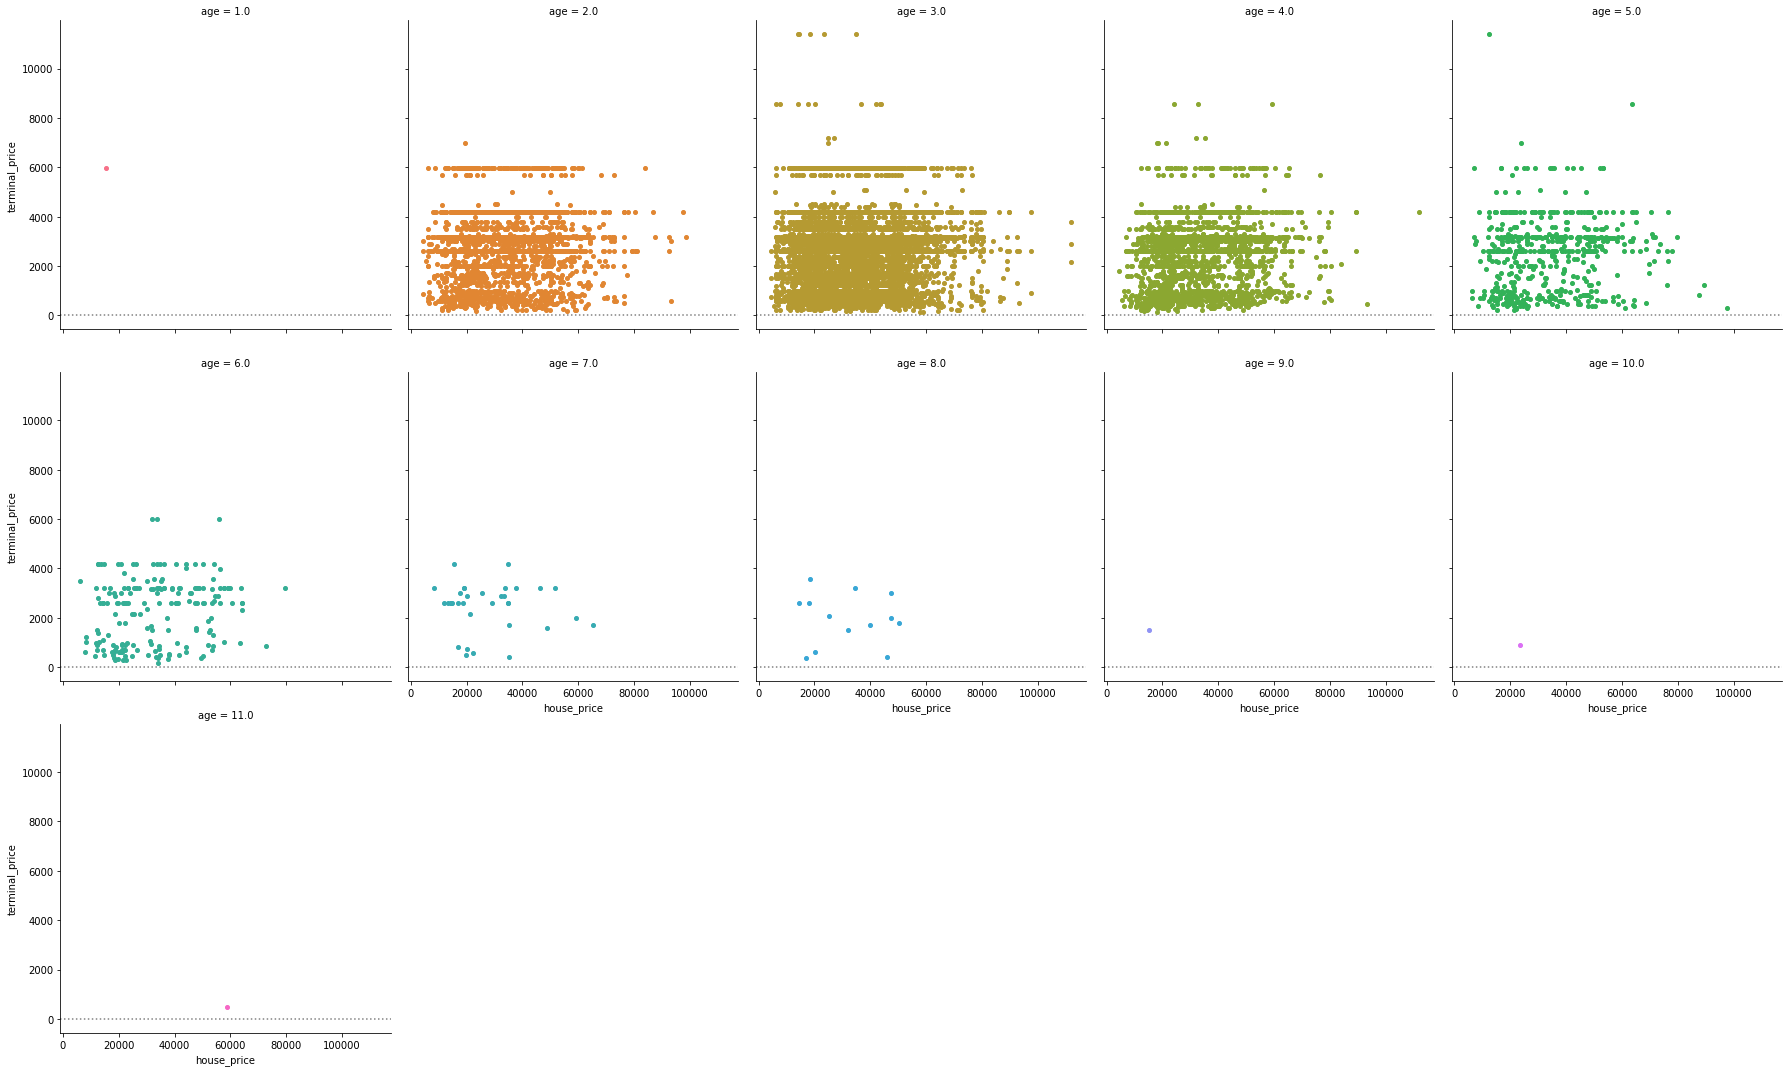

In [23]:
df=basename_except[["house_price", "terminal_price", "age"]]

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="age", hue="age", col_wrap=5, size=5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "house_price", "terminal_price", marker="o",linestyle = '', ms=4)

# Adjust the tick positions and labels
# grid.set(xticks=np.arange(5), yticks=[-3, 3],
#          xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
# grid.fig.tight_layout(w_pad=1)
plt.show()

In [31]:
basename_except.columns

Index(['user_id', 'sex', 'age', 'occupation_name', 'education_name',
       'user_opentime', 'brand_name', 'call_duration_m', 'gprs_flow',
       'call_fee', 'gprs_fee', 'databusiness_fee', 'brand_chn', 'model_chn',
       'screensize', 'operation_sys', 'terminal_price', 'dept_county_name',
       'dept_name', 'house_price', 'fees', 'record', 'location'],
      dtype='object')

In [38]:
basename_except['house_price']=basename_except['house_price']/1000

In [55]:
basename_except['terminal_price']=basename_except['terminal_price'].apply(lambda x:math.log(x))

In [56]:
reg = smf.ols('terminal_price ~ house_price+sex+age+call_duration_m+gprs_flow+call_fee+gprs_fee+\
databusiness_fee+screensize',
               data = basename_except).fit()
 
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         terminal_price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     33.73
Date:                Wed, 01 Aug 2018   Prob (F-statistic):           1.30e-58
Time:                        20:11:39   Log-Likelihood:                -6562.3
No. Observations:                6330   AIC:                         1.314e+04
Df Residuals:                    6320   BIC:                         1.321e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.3860      0.060    124.106      0.000       7.269       7.503
sex[T.Male]         -0.1104      0.019     -5.904      0.000      -0.147      -0.074
house_price          0.0424      0.006      7.357      0.000       0.031       0.054
age                 -0.0074      0.001     -6.367      0.000      -0.010      -0.005
call_duration_m      0.0001   1.16e-05      8.748      0.000    7.89e-05       0.000
gprs_flow        -8.047e-05   4.96e-05     -1.622      0.105      -0.000    1.68e-05
call_fee            -0.0002      0.000     -1.708      0.088      -0.001    3.55e-05
gprs_fee             0.0008      0.000      3.067      0.002       0.000       0.001
databusiness_fee    -0.0017      0.001     -3.016      0.003      -0.003      -0.001
screensize           0.0890      0.011      8.131      0.000       0.068       0.110
==============================================================================
Omnibus:                      679.730   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              923.335
Skew:                          -0.934   Prob(JB):                    3.16e-201
Kurtosis:                       3.097   Cond. No.                     8.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
male_20=basename_except[(basename_except['sex']=='Male')&(basename_except['age']==2)]

In [63]:
len(male_20)

2426

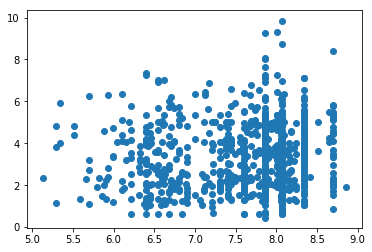

In [64]:
plt.scatter(male_20['terminal_price'],male_20['house_price'])

In [67]:
male_40=basename_except[(basename_except['sex']=='Male')&(basename_except['age']==4)]

In [69]:
len(male_40)

3183

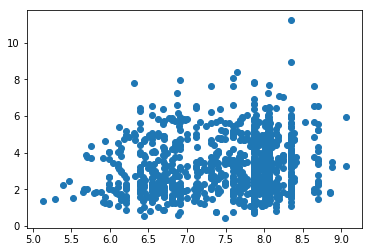

In [68]:
plt.scatter(male_40['terminal_price'],male_40['house_price'])

In [5]:
basename_except['sex']=basename_except['sex'].replace('Male',0)
basename_except['sex']=basename_except['sex'].replace('Female',1)

df=basename_except[['terminal_price','house_price','sex','age','call_duration_m','gprs_flow','call_fee','gprs_fee']]

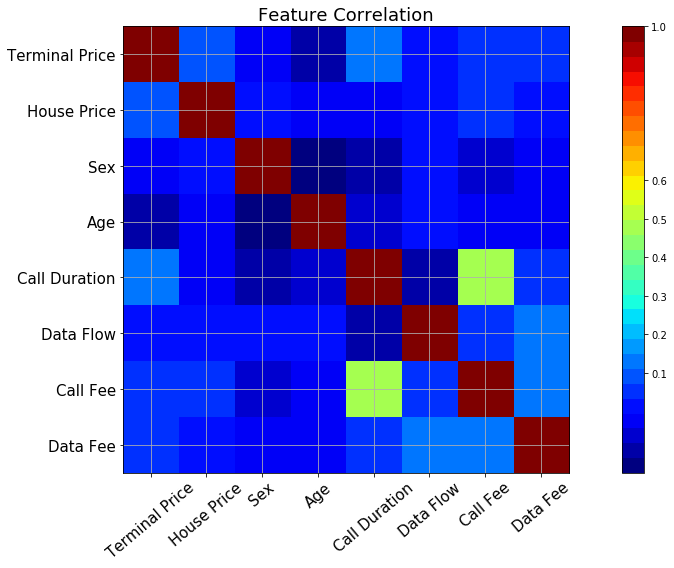

In [19]:
def correlation_matrix(df):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation',fontsize=18)
    labels=['0','Terminal Price','House Price','Sex','Age','Call Duration','Data Flow','Call Fee','Data Fee']
    ax1.set_xticklabels(labels,fontsize=15)
    ax1.set_yticklabels(labels,fontsize=15)
    plt.xticks(rotation=40)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0.1,0.2,.3,.4,.5,.6,1])
    plt.tight_layout()
    plt.savefig('./picture/correlation_matrix.png')
    plt.show()
    
    

correlation_matrix(df)

# user behavior information

In [4]:
column_list = 'user_id,access_mode_id,logic_area_name,lac,ci,longtitude,latitude,busi_name,busi_type_name,\
app_name,app_type_name,start_time,up_pack,down_pack,up_flow,down_flow,site_name,site_channel,\
cont_app_id,cont_classify_id,cont_type_id,acce_url'.split(',')

In [2]:
# 服务器

files=glob('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/allusers/*')
user_list = []
record_list = []
location_list = []
for f in files:
    data=pd.read_csv(f,index_col = 0, names = column_list)
    data['location'] = data['longtitude'].astype('str') + ',' + data['latitude'].astype('str')
    data = data[['user_id','location','start_time']]
    user = f.split('/')[-1].split('.')[0].split('_')[-1]
    user_list.append(user)
    record = data['start_time'].nunique()
    record_list.append(record)
    location = data['location'].nunique()
    location_list.append(location)    
    
df=pd.DataFrame([user_list,record_list,location_list]).T
df.columns=['user_id','record','location']
df.to_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/behavior.csv')

NameError: name 'glob' is not defined

In [12]:
behavior=pd.read_csv('./behavior.csv',index_col=0)

FileNotFoundError: File b'./behavior.csv' does not exist

In [6]:
behavior['record_d']=behavior['record']/31

In [135]:
behavior['record'].describe()

count    100000.000000
mean       7369.648480
std       11616.920355
min           1.000000
25%        1307.750000
50%        4178.500000
75%        9032.000000
max      351391.000000
Name: record, dtype: float64

In [7]:
behavior['record_d'].describe()

count    100000.000000
mean        237.730596
std         374.739366
min           0.032258
25%          42.185484
50%         134.790323
75%         291.354839
max       11335.193548
Name: record_d, dtype: float64

In [151]:
behavior['location'].describe()

count    100000.000000
mean         41.966720
std          52.372537
min           1.000000
25%          11.000000
50%          28.000000
75%          54.000000
max        1456.000000
Name: location, dtype: float64

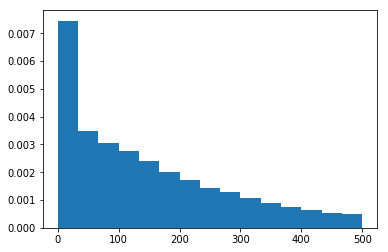

In [27]:
# other example
plt.hist(behavior['record_d'].values, range=(0,500),bins=15, normed=True)
plt.show()

# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="white", palette="muted", color_codes=True)
# # rs = np.random.RandomState(10)

# # Set up the matplotlib figure
# f, axes = plt.subplots(1,2,figsize=(10, 5))
# # sns.despine(left=True)

# # Generate a random univariate dataset
# d = behavior['location'].values
# e = behavior[''].values
# # Plot a simple histogram with binsize determined automatically
# # sns.distplot(d, kde=False, color="b")

# # Plot a kernel density estimate and rug plot
# # sns.distplot(d, hist=False, rug=True, color="r", ax=axes[0, 1])

# # Plot a filled kernel density estimate
# # sns.distplot(d, hist=False, color="g", kde_kws={"shade": True})

# # Plot a historgram and kernel density estimate
# sns.distplot(d,color="b",ax=axes[0])
# plt.xlim(0,400)

# sns.distplot(e,color="b", ax=axes[1])
# plt.xticks(range(50,250,50))
# # plt.setp(axes, yticks=[])
# plt.tight_layout()

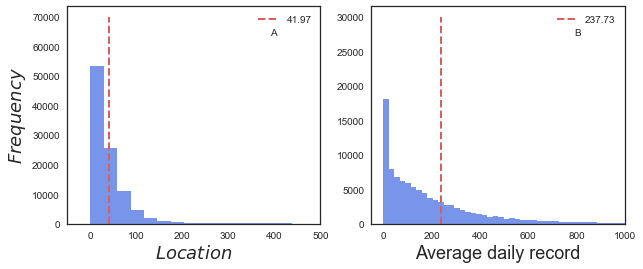

In [150]:
fig = plt.figure(figsize=(10, 4),facecolor='white')

ax = fig.add_subplot(121)
mz=np.mean(behavior['location'].values)
plt.plot([mz,mz],[0,70000],'r-',linewidth=2,linestyle='--',label=str(np.round(mz,2)))
plt.hist(behavior['location'].values,50,color='RoyalBlue',alpha=0.7)
plt.xlim(-50,500)
plt.legend(loc=1,frameon=False)
plt.ylabel(r'$Frequency$',size=18)
plt.xlabel(r'$Location $',size=18)
ax.text(0.8, 0.9,'A',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)

ax = fig.add_subplot(122)
mz=np.mean(behavior['record_d'].values)
plt.plot([mz,mz],[0,30000],'r-',linewidth=2,linestyle='--',label=str(np.round(mz,2)))
plt.hist(behavior['record_d'].values,500,color='RoyalBlue',alpha=0.7)
plt.xlim(-50,1000)
plt.legend(loc=1,frameon=False)
plt.xlabel('Average daily record',size=18)
ax.text(0.8, 0.9,'B',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)
plt.savefig('./picture/behavior.png',dpi=100)
plt.show()

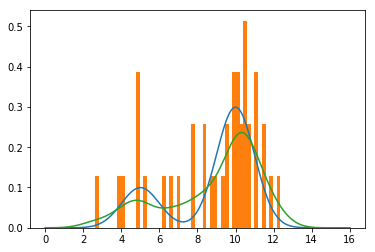

In [39]:
# other example

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
# from sklearn.neighbors import KernelDensity

# # Generate random samples from a mixture of 2 Gaussians
# # with modes at 5 and 10
# data = np.concatenate((5 + np.random.randn(10, 1),
#                        10 + np.random.randn(30, 1)))

# # Plot the true distribution
# x = np.linspace(0, 16, 1000)[:, np.newaxis]
# norm_vals = mlab.normpdf(x, 5, 1) * 0.25 + mlab.normpdf(x, 10, 1) * 0.75
# plt.plot(x, norm_vals)

# # Plot the data using a normalized histogram
# plt.hist(data, 50, normed=True)

# # Do kernel density estimation
# kd = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(data)

# # Plot the estimated densty
# kd_vals = np.exp(kd.score_samples(x))
# plt.plot(x, kd_vals)

# # Show the plots
# plt.show()

In [13]:
behavior=pd.read_csv('./basename_clean.csv',index_col=0)

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
behavior.head()

sex   age  occupation_name education_name  user_opentime brand_name  \
user_id                                                                        
50785931   男  75.0              NaN            NaN     20090102.0        神州行   
42280517   女   NaN              NaN            NaN     20100227.0        神州行   
40688293   男  24.0              NaN            NaN     20051226.0       动感地带   
31430787   男  28.0              NaN            NaN     20060211.0        全球通   
35548330   女   NaN              NaN            NaN     20060115.0       动感地带   

          call_duration_m  gprs_flow  call_fee  gprs_fee    ...       record  \
user_id                                                     ...                
50785931            515.0      51.92       NaN     10.00    ...       7686.0   
42280517            320.0      28.41     16.56     10.00    ...       2105.0   
40688293            283.0     132.16     25.00       NaN    ...       7909.0   
31430787           2447.0     339.84    295.52     43.08    ...      20385.0   
35548330           1330.0     110.28     39.08      0.00    ...       4337.0   

         location     N         E        AE         rg   A_N       A_E  \
user_id                                                                  
50785931     15.0  14.0  1.084929  1.025015   1.324190  23.0  2.475487   
42280517     16.0  16.0  1.461682  0.379559   6.419255   7.0  1.142861   
40688293     68.0  67.0  2.869684  1.048209   5.695152  22.0  2.397132   
31430787     82.0  81.0  2.556040  0.994136   5.678118  22.0  1.956815   
35548330     62.0  62.0  3.170161  2.253267  10.607778  22.0  2.462198   

              A_AE   category  
user_id                        
50785931  2.344932   low_high  
42280517  1.656604  high_high  
40688293  1.960756   low_high  
31430787  1.740311    low_low  
35548330  1.945497   high_low  

[5 rows x 35 columns]

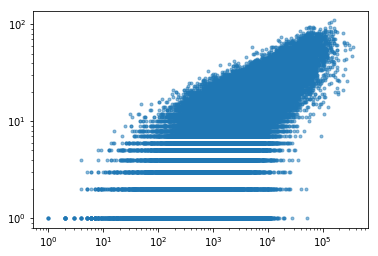

In [36]:
x=behavior['record']
y=behavior['A_N']
plt.plot(x, y,'.', alpha = .5)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [19]:
behavior['terminal_price']=behavior['terminal_price'].apply(lambda x:math.log(x))

In [38]:
behavior['record']=behavior['record'].apply(lambda x:math.log(x))

In [43]:
reg = smf.ols('record ~ A_N+A_AE+terminal_price+house_price+fees',
               data = behavior).fit()
 
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 record   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     4536.
Date:                Wed, 01 Aug 2018   Prob (F-statistic):               0.00
Time:                        21:46:55   Log-Likelihood:                -31040.
No. Observations:               25988   AIC:                         6.209e+04
Df Residuals:                   25982   BIC:                         6.214e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.2206      0.056    129.305      0.000       7.111       7.330
A_N                0.1067      0.001    146.892      0.000       0.105       0.108
A_AE              -0.7910      0.015    -54.413      0.000      -0.819      -0.762
terminal_price     0.0830      0.007     11.164      0.000       0.068       0.098
house_price     -8.75e-07   3.34e-07     -2.622      0.009   -1.53e-06   -2.21e-07
fees               0.0009   6.87e-05     13.247      0.000       0.001       0.001
==============================================================================
Omnibus:                     5565.262   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20278.264
Skew:                          -1.047   Prob(JB):                         0.00
Kurtosis:                       6.787   Cond. No.                     4.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# complete information user

In [119]:
columns = 'user_id，sex，age，occupation_name，education_name，user_opentime，brand_name，call_duration_m，gprs_flow，\
call_fee，gprs_fee，databusiness_fee，brand_chn，model_chn，screensize，operation_sys，terminal_price，\
dept_county_name，dept_name，house_price'.split('，')

basename_except = pd.read_csv('./basename_except.csv', names=columns)

basename_except['fees']=basename_except['call_fee']+basename_except['gprs_fee']+basename_except['databusiness_fee']

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
basename_except = basename_except[['user_id','gprs_flow','terminal_price',
                                   'fees','call_duration_m','house_price']]
basename_except = basename_except.dropna(axis=0,how='any')

In [121]:
users=basename_except['user_id'].unique()

In [122]:
len(users)

9350

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


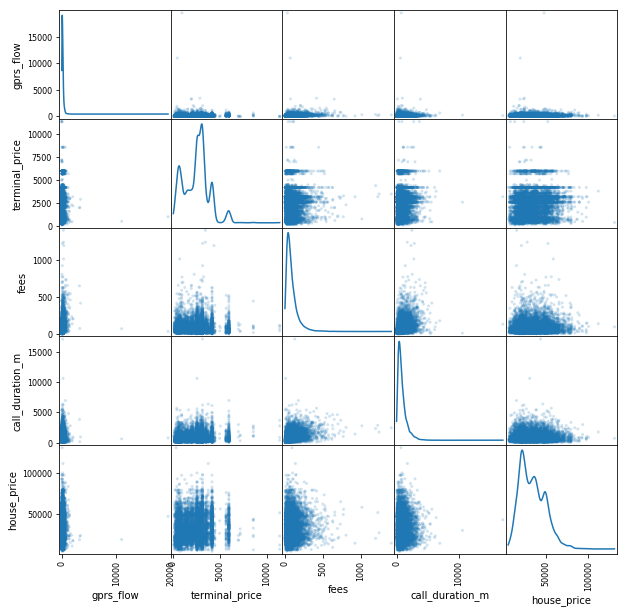

In [124]:
scatter_matrix(basename_except[['gprs_flow','terminal_price','fees','call_duration_m',
                                'house_price']],alpha=0.2,figsize=(10,10),diagonal='kde')
plt.show()